In [1]:
from IPython.display import clear_output
!pip install chart-studio
clear_output()
from sklearn.impute import KNNImputer
import seaborn as sns
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold, KFold
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from datetime import datetime as dt
import itertools
from tqdm import tqdm
from scipy.stats import norm, t
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
import gc
# from sklearn.model_selection import 
from sklearn import metrics
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_columns', None)
# plt.style.use('fivethirtyeight') 
from pylab import rcParams
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from statsmodels.tsa.arima_model import ARMA
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
from catboost import Pool, CatBoostRegressor
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from keras.callbacks import EarlyStopping
import os 
import random
# import numpy as np 
from catboost import Pool, CatBoostRegressor

DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# tensorflow random seed 
import tensorflow as tf 
def seedTF(seed=DEFAULT_RANDOM_SEED):
    tf.random.set_seed(seed)
    
# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
# basic + tensorflow + torch 
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTF(seed)
    seedTorch(seed)
seedEverything(42)
seed = 42


# Load data

In [2]:
train_ori = pd.read_csv('/kaggle/input/airquoi/train.csv',parse_dates=['date'])
test_ori = pd.read_csv('/kaggle/input/airquoi/test.csv',parse_dates=['date'])
ss =pd.read_csv('/kaggle/input/airquoi/SampleSubmission.csv')

# Helper functions

In [497]:

def filter_bad(train,test,models,features,
               target,metric,typ = 'xgb',weigthed = True,th = 0.5):
    train_preds = []
    test_preds = []
    if typ == 'xgb':
        for model in models:
            train_preds.append(model.predict(xgb.DMatrix(train[features].values), 
                            ntree_limit=model.best_ntree_limit))
            test_preds.append(model.predict(xgb.DMatrix(test[features].values), 
                            ntree_limit=model.best_ntree_limit))
    elif typ == 'lgb':
        for model in models:
            train_preds.append(model.predict(train[features].values,
                                             num_iteration=model.best_iteration))
            test_preds.append(model.predict(test[features].values,
                                             num_iteration=model.best_iteration))
    elif typ == 'cat':
        for model in models:
            train_preds.append(model.predict(train[features].values))
            test_preds.append(model.predict(test[features].values))
    
    
    scores = [ metric(train[target].values , preds) for preds in train_preds]
    test_preds_2 = [i for i,j in zip(test_preds,scores) if j<th ]
    weights = [1/w for w in scores if w<th]
    if len(weights)<2:
        sco = max(scores)
        final_preds = None
    else:
        final_preds = np.average(np.vstack(test_preds_2),axis = 0,weights=weights)
        train_preds_2 = [i for i,j in zip(train_preds,scores) if j<th ]
    #     weights = [1/w for w in scores[scores<th]]
        final_preds_train = np.average(np.vstack(train_preds_2),axis = 0,weights=weights)
        sco = metrics.mean_absolute_error(train[target],final_preds_train)
    print(f"weighted average  score is {sco}")
    return final_preds,final_preds_train,sco


def my_cust_shift(df,n):
    ind = df.sort_values('date').index
    x = df.set_index('date').sort_index()['pm2_5'] 
    a = x.shift(n, freq='D')
    b = x.index
    val = pd.Series(index = b,data = np.nan)
    val = val.fillna(a)
    val.index = ind
    return val.sort_index()
def my_cust_rolling_mean(df,n,quant = 'mean',fact = 2,shift = None,strat = 'cust',target = 'pm2_5'):
    ind = df.sort_values('date').index
    x = df.set_index('date').sort_index()[target]
#     x_plain = df.sort_values('date')['pm2_5'].reset_index(drop = True)
    if quant == 'mean':
        a = x.rolling(str(n)+'D',min_periods=round(n/fact)).mean()
        if strat =='plain':
            a = x.rolling(n,min_periods=round(n/fact)).mean()
    elif quant == 'std':
        a = x.rolling(str(n)+'D',min_periods=round(n/fact)).std()
        if strat == 'plain':
            a = x.rolling(n,min_periods=round(n/fact)).std()
    elif quant == 'min':
        a = x.rolling(str(n)+'D',min_periods=round(n/fact)).min()
        if strat == 'plain':
            a = x.rolling(n,min_periods=round(n/fact)).min()
    elif quant == 'max':
        a = x.rolling(str(n)+'D',min_periods=round(n/fact)).max()
        if strat == 'plain':
            a = x.rolling(n,min_periods=round(n/fact)).max()
    b = x.index
    val = pd.Series(index = b,data = np.nan)
    val = val.fillna(a)
    if shift:
        val = val.reset_index()
        val.columns = ['date',target]
        val = my_cust_shift(val,shift)
    val.index = ind
    return val.sort_index()
def rolling_lags(train,test,TARGET,groups,windows,lags):
    temp_df = pd.concat([train,test]).reset_index()
#     temp_df = temp_df.set_index('date').sort_index()
    mask = (temp_df.site_code!=17)
    for i in windows:
#         print('Rolling period:', i)
        temp_df['rolling_mean_'+TARGET+str(i)] = np.nan
        temp_df['rolling_std_'+TARGET+str(i)] = np.nan
        temp_df['rolling_min_'+TARGET+str(i)] = np.nan
        temp_df['rolling_max_'+TARGET+str(i)] = np.nan
        temp_df.loc[mask,'rolling_mean_'+TARGET+str(i)] = temp_df[mask].groupby(groups).apply(lambda x: my_cust_rolling_mean(x,i,quant = 'mean',fact = 2,shift = i)).reset_index(drop = True,level = 0).sort_index()
        temp_df.loc[mask,'rolling_std_'+TARGET+str(i)]  = temp_df[mask].groupby(groups).apply(lambda x: my_cust_rolling_mean(x,i,quant = 'std',fact = 2,shift = i)).reset_index(drop = True,level = 0).sort_index()
        temp_df.loc[mask,'rolling_min_'+TARGET+str(i)] = temp_df[mask].groupby(groups).apply(lambda x: my_cust_rolling_mean(x,i,quant = 'min',fact = 2,shift = i)).reset_index(drop = True,level = 0).sort_index()
        temp_df.loc[mask,'rolling_max_'+TARGET+str(i)]  = temp_df[mask].groupby(groups).apply(lambda x: my_cust_rolling_mean(x,i,quant = 'max',fact = 2,shift = i)).reset_index(drop = True,level = 0).sort_index()
    for i in lags:
        temp_df['lagged_'+TARGET+str(i)] = np.nan
        temp_df.loc[mask,'lagged_'+TARGET+str(i)] = temp_df[mask].groupby(groups).apply(lambda x: my_cust_shift(x,i)).reset_index(drop = True,level = 0).sort_index()
    tr,te = temp_df[temp_df.Train == 1].set_index('index'), temp_df[temp_df.Train == 0].set_index('index')
#     tr.index = train.sort_values('date').index
#     te.index = test.sort_values('date').index
    
    return tr.sort_index(), te.sort_index() 

def get_prev(df,shifts = 1,col = 'pm2_5'):
    df['shifted_'+str(shifts)] = df.shift(shifts)[col].values
    return df
def target_encode(df_train,df_test,target,groupss):
    groupss_target_mean = df_train.groupby(groupss)[target].mean()
    groupss_target_max = df_train.groupby(groupss)[target].max()
    groupss_target_min = df_train.groupby(groupss)[target].min()
    groupss_target_std = df_train.groupby(groupss)[target].std()
    groupss_target_median = df_train.groupby(groupss)[target].apply(lambda x : np.median(x))
    groupss_target_q95 = df_train.groupby(groupss)[target].apply(lambda x : np.quantile(x,0.95))
    groupss_target_q05 = df_train.groupby(groupss)[target].apply(lambda x : np.quantile(x,0.05))
    groupss_target_skew = df_train.groupby(groupss)[target].skew()
    groupss_target_kurt = df_train.groupby(groupss)[target].apply(lambda x : x.kurtosis())
    # groupss_target_mean = df_train.groupby(groupss)[target].mean()
    df_test[groupss+target+'enc'] = df_test[groupss].map(groupss_target_mean)
    df_test[groupss+target+'enc'].fillna((df_test[groupss+target+'enc'].mean()), inplace=True)
    df_test[groupss+target+'enc1'] = df_test[groupss].map(groupss_target_max)
    df_test[groupss+target+'enc1'].fillna((df_test[groupss+target+'enc1'].mean()), inplace=True)
    df_test[groupss+target+'enc2'] = df_test[groupss].map(groupss_target_min)
    df_test[groupss+target+'enc2'].fillna((df_test[groupss+target+'enc2'].mean()), inplace=True)
    df_test[groupss+target+'enc3'] = df_test[groupss].map(groupss_target_std)
    df_test[groupss+target+'enc3'].fillna((df_test[groupss+target+'enc3'].mean()), inplace=True)
    df_test[groupss+target+'enc4'] = df_test[groupss].map(groupss_target_median)
    df_test[groupss+target+'enc4'].fillna((df_test[groupss+target+'enc4'].mean()), inplace=True)
    df_test[groupss+target+'enc5'] = df_test[groupss].map(groupss_target_q95)
    df_test[groupss+target+'enc5'].fillna((df_test[groupss+target+'enc5'].mean()), inplace=True)
    df_test[groupss+target+'enc6'] = df_test[groupss].map(groupss_target_q05)
    df_test[groupss+target+'enc6'].fillna((df_test[groupss+target+'enc6'].mean()), inplace=True)
    df_test[groupss+target+'enc7'] = df_test[groupss].map(groupss_target_skew)
    df_test[groupss+target+'enc7'].fillna((df_test[groupss+target+'enc7'].mean()), inplace=True)
    df_test[groupss+target+'enc8'] = df_test[groupss].map(groupss_target_kurt)
    df_test[groupss+target+'enc8'].fillna((df_test[groupss+target+'enc8'].mean()), inplace=True)
    tmp =np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].apply(lambda x : x.skew())
        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc7'] = tmp
    tmp =np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].apply(lambda x : x.kurtosis())

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc8'] = tmp
    
    tmp =np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].apply(lambda x : np.quantile(x,0.05))

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc6'] = tmp
    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1991032)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].apply(lambda x : np.quantile(x,0.95))

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc5'] = tmp



    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1991035)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].apply(lambda x : np.median(x))

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc4'] = tmp



    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].mean()

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc'] = tmp



    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1991025)
    for idx_1, idx_2 in kf.split(df_train):
        target_max = df_train.iloc[idx_1].groupby(groupss)[target].max()

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_max)
    df_train[groupss+target+'enc1'] = tmp
    # from sklearn.model_selection import KFold/
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1990325)
    for idx_1, idx_2 in kf.split(df_train):
        target_min = df_train.iloc[idx_1].groupby(groupss)[target].min()

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_min)
    df_train[groupss+target+'enc2'] = tmp
    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_std = df_train.iloc[idx_1].groupby(groupss)[target].std()

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_std)
    df_train[groupss+target+'enc3'] = tmp
    df_train[groupss+target+'enc'].fillna((df_train[groupss+target+'enc'].mean()), inplace=True)
    df_train[groupss+target+'enc1'].fillna((df_train[groupss+target+'enc1'].mean()), inplace=True)
    df_train[groupss+target+'enc2'].fillna((df_train[groupss+target+'enc2'].mean()), inplace=True)
    df_train[groupss+target+'enc3'].fillna((df_train[groupss+target+'enc3'].mean()), inplace=True)
    df_train[groupss+target+'enc4'].fillna((df_train[groupss+target+'enc4'].mean()), inplace=True)
    df_train[groupss+target+'enc5'].fillna((df_train[groupss+target+'enc5'].mean()), inplace=True)
    df_train[groupss+target+'enc6'].fillna((df_train[groupss+target+'enc6'].mean()), inplace=True)
    return df_train, df_test

def cust_metric(y_pred, ds):
    y_true = ds.get_label()
    sq_errs = abs(y_true - y_pred)
    avg_per_id = pd.Series(sq_errs).groupby(ds.site_code).mean()
#     print(avg_per_id)
    return 'avg_worst_by_id', avg_per_id.max(), False

def _get_X_Y_DF_from_CV(train_X, train_Y, train_index, validation_index):
        X_train, X_validation = (
            train_X.iloc[train_index],
            train_X.iloc[validation_index],
        )
        y_train, y_validation = (
            train_Y.iloc[train_index],
            train_Y.iloc[validation_index],
        )
        return X_train, X_validation, y_train, y_validation
def cust_score(y_predicted,train):
    l = []
    a = train.site_latitude.unique()
    for i in a:
        y_true = train.loc[train.site_latitude == i,'pm2_5']
        y_hat = y_predicted[y_true.index]
        l.append(metrics.mean_absolute_error(y_true,y_hat))
    return pd.DataFrame({'site_latitude':a,
                        'err': np.array(l)}).sort_values('err',ascending = False)
def preds_to_sub(test,preds,name = None,log = False):
    if log :
        test['pm2_5'] = np.exp(preds)
    else:
        test['pm2_5'] = preds
    sub = test[['ID','pm2_5']]
    if name:
        sub.to_csv(name+'.csv', index = False)
    return sub
def masked_w_aver(a,weights):
    ma = np.ma.MaskedArray(a, mask=np.isnan(a))
    return np.ma.average(ma, weights=weights)
def auto_regress(train,test,i,col_tar,output_col,preds_col):
    a = train.site_latitude.unique()
    time_ser = fancy_interpol(train,i,th=0.8,col_pred = 'pm2_5',col_tar = col_tar)
    time_ser = time_ser.resample('D').mean().interpolate()
    
    time_ser_test = test.loc[test.site_latitude == a[i]].sort_values(by = 'date').copy()
    time_ser_test.index = time_ser_test.date 
    time_ser_test = (time_ser_test[output_col])
    time_ser_test = time_ser_test.resample('D').mean().interpolate()

    train_sample = time_ser.values
    p_val = 0.05
    try:
        seas  = 1
        model = sm.tsa.SARIMAX(train_sample,order=(2,1,0),enforce_stationarity=True,
                       seasonal_order=(0,0,1,7),trend= None)
        result = model.fit(maxiter=1000,disp=False)
        assert result.pvalues[2]<p_val
    except:
        seas = 0
        model = sm.tsa.SARIMAX(train_sample,order=(2,1,0),trend=None)
        result = model.fit(maxiter=1000,disp=False)
#     print(result.summary())
#     predicted_result = result.predict(start=1, end=train_sample.shape[0]-1)
    y_true_dates = train.loc[train.site_latitude == a[i]].sort_values(by = 'date')['date'].values
    y_true = train.loc[train.site_latitude == a[i]].sort_values(by = 'date')['pm2_5'].values
    y_hat = train.loc[train.site_latitude == a[i]].sort_values(by = 'date')[preds_col].values
    correct = result.predict(start=1, end=time_ser.shape[0]+time_ser_test.shape[0])
    y_true_dates_test = test.loc[test.site_latitude == a[i]].sort_values(by = 'date')['date'].values
    mask_train = time_ser.index.isin(y_true_dates)
    mask_test = time_ser_test.index.isin(y_true_dates_test)
    train = train.sort_values('date')
    test = test.sort_values('date')
    
    train.loc[(train.site_latitude == a[i]) & (train.date>= time_ser.index.min()),output_col] = correct[:time_ser.shape[0]][mask_train]
    test.loc[test.site_latitude == a[i],output_col] = correct[time_ser.shape[0]:][mask_test]
#     train.loc[train.site_latitude == a[i],'seas'] = seas
#     test.loc[test.site_latitude == a[i],'seas'] = seas
    train = train.sort_index()
    test = test.sort_index()
    return train, test
def fancy_interpol(train,i,th=0.8,col_pred = 'pm2_5',col_tar = 'pm2_5'):
#     th = 0.8
    a = train.site_latitude.unique()
    mi = train.pivot(index = 'date',columns = 'site_latitude',values = col_tar)[a[i]].dropna().index.min()
    ma = train.pivot(index = 'date',columns = 'site_latitude',values = col_tar)[a[i]].dropna().index.max()

    df_pred = train.pivot(index = 'date',columns = 'site_latitude',values = col_pred)[mi:ma]
    df_tar = train.pivot(index = 'date',columns = 'site_latitude',values = col_tar)[mi:ma]

    w_s = df_pred.corr()[a[i]].sort_values(ascending = False)
    filtered_ws = w_s[(w_s>th)& (w_s<1)]
    if len(filtered_ws)*len(df_tar[df_tar[a[i]].isna()])>0 : 
        df_tar.loc[df_tar[a[i]].isna(),a[i]] = df_tar.loc[df_tar[a[i]].isna(),filtered_ws.index].apply(lambda x: masked_w_aver(x, weights=filtered_ws.values),axis = 1)
    return df_tar.loc[mi:ma,a[i]].astype('float')
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=False)[:10].index
    best_features = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=False)[:50]
    best_features.reset_index(inplace=True)
    print(best_features.dtypes)
    plt.figure(figsize=(8, 10))
    sns.barplot(x="Importance", y="Feature", data=best_features)
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
def rolling_lags_plain(train,test,TARGET,groups,windows,lags):
    temp_df = pd.concat([train,test]).sort_values('date').reset_index(drop = True)
    for i in windows:
#         print('Rolling period:', i)
        temp_df['rolling_mean_'+TARGET+str(i)] = temp_df.groupby(groups)[TARGET].transform(lambda x: x.shift(i).rolling(i).mean())
        temp_df['rolling_std_'+TARGET+str(i)]  = temp_df.groupby(groups)[TARGET].transform(lambda x: x.shift(i).rolling(i).std())
        temp_df['rolling_min_'+TARGET+str(i)] = temp_df.groupby(groups)[TARGET].transform(lambda x: x.shift(i).rolling(i).min())
        temp_df['rolling_max_'+TARGET+str(i)]  = temp_df.groupby(groups)[TARGET].transform(lambda x: x.shift(i).rolling(i).max())
    for i in lags:
        temp_df['lagged_'+TARGET+str(i)] = temp_df.groupby(groups)[TARGET].transform(lambda x: x.shift(i).fillna(method = 'ffill'))
    tr,te = temp_df[temp_df.Train == 1].reset_index(drop = True), temp_df[temp_df.Train == 0].reset_index(drop = True) 
    tr.index = train.sort_values('date').index
    te.index = test.sort_values('date').index
    
    return tr.sort_index(), te.sort_index() 
# train['date_id'] =(train['date'] - train.date.min()).dt.days
# test['date_id'] =


# Preprocessing

In [466]:
# x = train1.groupby('site_code').get_group(0).set_index('date').sort_index()['pm2_5']

In [467]:
# x.rolling(10).mean()

In [490]:
def preprocess(train,test,scale = True,target_encod = False, lagss = True,
               include_date = True,remove_nans = True, remove_multi = True,strat_roll = 'plain'):
    original_train = train.ID.values
    original_test = test.ID.values
    le = LabelEncoder()
    train['Train']=1
    test['Train']=0
    all_data=pd.concat([train,test])
    other_cols = ['pm2_5', 'Train', 'month', 'year', 'day',
               'week', 'dow', 'woy', 'rel_date']
    if include_date:
        all_data['month'] = all_data.date.dt.month
        all_data['year'] = all_data.date.dt.year
        all_data['day'] = all_data.date.dt.day
        all_data['week'] = all_data.date.dt.week
        all_data['dow'] = all_data.date.dt.dayofweek
        all_data['woy'] = all_data.date.dt.weekofyear
    all_data['date_id'] = (all_data['date'] - all_data.date.min()).dt.days
    all_data[['site_latitude','site_longitude']] =  all_data[['site_latitude','site_longitude']] .round(5)
    all_data['device'] = le.fit_transform(all_data['device'].values.reshape(-1,1))
    le = LabelEncoder()
    all_data['site_code'] = le.fit_transform(all_data.site_latitude.astype('str').values.reshape(-1,1))
    train = all_data.loc[all_data.Train == 1].reset_index(drop = True)
    test = all_data.loc[all_data.Train == 0].reset_index(drop = True)
    if target_encod:
        train,test = target_encode(train,test,target = 'pm2_5',groupss = 'site_code')
    if lagss:
        ws = [7,30,60,130]
        ls = [7,30,60,120]
#         test.loc[(test['site_code'] == 17) & (test['date'] == '2020-10-17')  & (test['device'] == 35) ,'date' ]+= timedelta(hours = 2)
        if strat_roll == 'cust':
            train,test = rolling_lags(train,test,'pm2_5','site_code',ws,ls)
            train,test = rolling_lags(train,test,'humidity','site_code',ws,ls)
            train,test = rolling_lags(train,test,'temp_mean','site_code',ws,ls)
            
        else:
            train,test = rolling_lags_plain(train,test,'pm2_5','site_code',ws,ls)
            train,test = rolling_lags_plain(train,test,'humidity','site_code',ws,ls)
            train,test = rolling_lags_plain(train,test,'temp_mean','site_code',ws,ls)
    if remove_nans:
        tr,te = cust_imputer(train.copy(), test.copy())
        all_data = pd.concat([tr,te]).reset_index(drop = True)
        s_codes = all_data.site_code.unique()
        distances = np.zeros((s_codes.shape[0],s_codes.shape[0]))
        for i in np.sort(s_codes):
            for j in np.sort(s_codes):
                distances[i,j] =  get_dist(all_data, i,j)
        distances = pd.DataFrame(index = np.sort(s_codes), columns = np.sort(s_codes),data = distances)
        SO2_cols = ['SulphurDioxide_SO2_column_number_density',
                    'SulphurDioxide_SO2_column_number_density_amf',
               'SulphurDioxide_SO2_slant_column_number_density',
               'SulphurDioxide_cloud_fraction',
                'SulphurDioxide_sensor_azimuth_angle',
               'SulphurDioxide_sensor_zenith_angle',
               'SulphurDioxide_solar_azimuth_angle',
               'SulphurDioxide_solar_zenith_angle',
               'SulphurDioxide_SO2_column_number_density_15km']
        CO_cols = ['CarbonMonoxide_CO_column_number_density',
               'CarbonMonoxide_H2O_column_number_density',
               'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude',
               'CarbonMonoxide_sensor_azimuth_angle',
               'CarbonMonoxide_sensor_zenith_angle',
               'CarbonMonoxide_solar_azimuth_angle',
               'CarbonMonoxide_solar_zenith_angle']
        NO2_cols = ['NitrogenDioxide_NO2_column_number_density',
               'NitrogenDioxide_tropospheric_NO2_column_number_density',
               'NitrogenDioxide_stratospheric_NO2_column_number_density',
               'NitrogenDioxide_NO2_slant_column_number_density',
               'NitrogenDioxide_tropopause_pressure',
               'NitrogenDioxide_absorbing_aerosol_index',
               'NitrogenDioxide_cloud_fraction', 'NitrogenDioxide_sensor_altitude',
               'NitrogenDioxide_sensor_azimuth_angle',
               'NitrogenDioxide_sensor_zenith_angle',
               'NitrogenDioxide_solar_azimuth_angle',
               'NitrogenDioxide_solar_zenith_angle']
        HCHO_cols = ['Formaldehyde_tropospheric_HCHO_column_number_density',
               'Formaldehyde_tropospheric_HCHO_column_number_density_amf',
               'Formaldehyde_HCHO_slant_column_number_density',
               'Formaldehyde_cloud_fraction', 'Formaldehyde_solar_zenith_angle',
               'Formaldehyde_solar_azimuth_angle', 'Formaldehyde_sensor_zenith_angle',
               'Formaldehyde_sensor_azimuth_angle']
        UV_cols = ['UvAerosolIndex_absorbing_aerosol_index',
               'UvAerosolIndex_sensor_altitude', 'UvAerosolIndex_sensor_azimuth_angle',
               'UvAerosolIndex_sensor_zenith_angle',
               'UvAerosolIndex_solar_azimuth_angle',
               'UvAerosolIndex_solar_zenith_angle']
        O3_cols = ['Ozone_O3_column_number_density_amf',
               'Ozone_O3_slant_column_number_density',
               'Ozone_O3_effective_temperature', 'Ozone_cloud_fraction',
               'Ozone_sensor_azimuth_angle', 'Ozone_sensor_zenith_angle',
               'Ozone_solar_azimuth_angle', 'Ozone_solar_zenith_angle']
        cloud_cols = ['Cloud_cloud_fraction', 'Cloud_cloud_top_pressure',
               'Cloud_cloud_top_height', 'Cloud_cloud_base_pressure',
               'Cloud_cloud_base_height', 'Cloud_cloud_optical_depth',
               'Cloud_surface_albedo', 'Cloud_sensor_azimuth_angle',
               'Cloud_sensor_zenith_angle', 'Cloud_solar_azimuth_angle',
               'Cloud_solar_zenith_angle']
        target = ['pm2_5']
        all_cols = SO2_cols+cloud_cols+O3_cols+UV_cols+HCHO_cols+NO2_cols+CO_cols

        other_cols_test = ['Train', 'month', 'year', 'day',
               'week', 'dow', 'woy', 'rel_date']
        for col in tqdm(all_cols):
            for s_co in s_codes:
                all_data = distance_w_impute(col,s_co,all_data,distances)
        kn = KNNImputer(n_neighbors=5)
        cols = all_data.drop('pm2_5',axis = 1).select_dtypes(include = ['float']).columns
        all_data[cols] = kn.fit_transform(all_data[cols])
        test = all_data[all_data.ID.isin(test_ori.ID)].drop_duplicates().reset_index(drop = True)
        train = all_data[all_data.ID.isin(train_ori.ID)].drop_duplicates().reset_index(drop = True)
        
#         test[cols] = kn.transform(test[cols])
#         cols = 
        if scale:
            rs= RobustScaler()
            train[cols] = rs.fit_transform(train[cols])
            test[cols] = rs.transform(test[cols])
    if remove_multi:
        cols = train.select_dtypes(include = ['float']).columns
        l_drop = []
        for col in cols:
            df = train.pivot(index = 'date',columns = 'site_code',values = col)
            if df.corr().mean().mean()>0.99:
                l_drop.append(col)
        train = train.drop([l for l  in l_drop[1:] if l not in other_cols],axis = 1 )
        test = test.drop([l for l  in l_drop[1:] if l not in other_cols],axis = 1 )
    train = train.set_index('ID')
    test = test.set_index('ID')
    train = train.loc[original_train]
    test = test.loc[original_test]
    train, test = train.reset_index(), test.reset_index()
    return train, test
def get_dist(all_data, i,j):
    return np.sqrt((all_data.loc[all_data.site_code == i,'site_latitude'].unique()[0]- all_data.loc[all_data.site_code == j,'site_latitude'].unique()[0])**2 + (all_data.loc[all_data.site_code == i,'site_longitude'].unique()[0]- all_data.loc[all_data.site_code == j,'site_longitude'].unique()[0])**2)

def distance_w_impute(col,s_co,all_data,distances):
    ind = all_data.loc[(all_data.site_code == s_co)& (all_data[col].isna()),'date'].values
    df3 = all_data.loc[(all_data.site_code != s_co)& (all_data.date.isin(ind)),['date',col,'site_code']]
    df3['weights'] = df3['site_code'].map(distances[s_co]**(-1))
    df3[col] = df3[col]*df3['weights']
    maps = df3.groupby('date').apply(lambda x : x[col].sum()/(x['weights'].sum()))
    all_data.loc[(all_data.site_code == s_co)& (all_data[col].isna()),col] = all_data.loc[(all_data.site_code == s_co)& (all_data[col].isna()),'date'].map(maps)
    return all_data
def cust_imputer(train, test):
    all_data = pd.concat([train,test]).reset_index(drop = True)
    sensor_az_ang = ['SulphurDioxide_sensor_azimuth_angle','CarbonMonoxide_sensor_azimuth_angle','NitrogenDioxide_sensor_azimuth_angle',
          'Formaldehyde_sensor_azimuth_angle','UvAerosolIndex_sensor_azimuth_angle','Ozone_sensor_azimuth_angle',
         'Cloud_sensor_azimuth_angle']
    sensor_zen_ang = ['SulphurDioxide_sensor_zenith_angle','CarbonMonoxide_sensor_zenith_angle','NitrogenDioxide_sensor_zenith_angle',
          'Formaldehyde_sensor_zenith_angle','UvAerosolIndex_sensor_zenith_angle','Ozone_sensor_zenith_angle',
         'Cloud_sensor_zenith_angle']
    solar_az_ang = ['SulphurDioxide_solar_azimuth_angle','CarbonMonoxide_solar_azimuth_angle','NitrogenDioxide_solar_azimuth_angle',
          'Formaldehyde_solar_azimuth_angle','UvAerosolIndex_solar_azimuth_angle','Ozone_solar_azimuth_angle',
         'Cloud_solar_azimuth_angle']
    solar_zen_ang = ['SulphurDioxide_solar_zenith_angle','CarbonMonoxide_solar_zenith_angle','NitrogenDioxide_solar_zenith_angle',
          'Formaldehyde_solar_zenith_angle','UvAerosolIndex_solar_zenith_angle','Ozone_solar_zenith_angle',
         'Cloud_solar_zenith_angle']
    X =  all_data[sensor_az_ang]
    imputer = KNNImputer(n_neighbors=5)
    all_data.loc[X.isna().sum(axis = 1)<7,sensor_az_ang] = imputer.fit_transform(X[X.isna().sum(axis = 1)<7]) 
    X =  all_data[sensor_zen_ang]
    imputer = KNNImputer(n_neighbors=5)
    all_data.loc[X.isna().sum(axis = 1)<7,sensor_zen_ang] = imputer.fit_transform(X[X.isna().sum(axis = 1)<7])
    X =  all_data[solar_az_ang]
    imputer = KNNImputer(n_neighbors=5)
    all_data.loc[X.isna().sum(axis = 1)<7,solar_az_ang] = imputer.fit_transform(X[X.isna().sum(axis = 1)<7]) 
    X =  all_data[solar_zen_ang]
    imputer = KNNImputer(n_neighbors=5)
    all_data.loc[X.isna().sum(axis = 1)<7,solar_zen_ang] = imputer.fit_transform(X[X.isna().sum(axis = 1)<7])
    return all_data.loc[:train.shape[0]], all_data.loc[train.shape[0]:]


In [469]:
def preprocess_old(train,test):
    le = LabelEncoder()
    train['Train']=1
    test['Train']=0
#     home_teams=train['Home Team'].unique()
    all_data=pd.concat([train,test])
    all_data['month'] = all_data.date.dt.month
    all_data['year'] = all_data.date.dt.year
    all_data['day'] = all_data.date.dt.day
    all_data['week'] = all_data.date.dt.week
    all_data['dow'] = all_data.date.dt.dayofweek
    all_data['woy'] = all_data.date.dt.weekofyear
    all_data[['site_latitude','site_longitude']] =  all_data[['site_latitude','site_longitude']] .round(5)
#     for c in all_data.drop(['date','pm2_5'], axis = 1).select_dtypes(exclude = 'object').columns:
#         all_data[c] = all_data[c].fillna(all_data[c].min()-1)
#     all_data['rel_date'] = all_data.groupby('site_latitude').apply(lambda x : ((x.date-x.date.min())/ np.timedelta64(1, 'D')).astype('int') +1).reset_index()['date']

    all_data['device'] = le.fit_transform(all_data['device'].values.reshape(-1,1))
    le = LabelEncoder()
#     all_data['site_code'] = le.fit_transform(all_data.site_latitude.astype('str').values.reshape(-1,1))
#     all_data = get_prev(all_data.reset_index(drop = True),shifts = 1,col = 'pm2_5')
    train = all_data.loc[all_data.Train == 1].reset_index(drop = True)
    test = all_data.loc[all_data.Train == 0].reset_index(drop = True)
#     train, test = interpol(train,test)
#     train,test = target_encode(train,test,target = 'pm2_5',groupss = 'site_latitude')
    return train, test


In [470]:
# tr,te = preprocess_old(train_ori,test_ori)
train_ori_loc = train_ori.loc[train_ori.date<'2020-04-23'].reset_index(drop = True )
test_ori_loc = train_ori.loc[train_ori.date>= '2020-04-23'].reset_index(drop = True )
y_true_loc = test_ori_loc['pm2_5']
test_ori_loc.drop('pm2_5',axis = 1, inplace = True)

In [471]:
# san = (train2[tr.columns] == tr).all()
# test_ori_loc.ID

In [472]:
# san[san == False]

In [473]:
# san[san == False]
# tr['temp_mean'].describe() - train1['temp_mean'].describe()
# (tr[san[san == False].index]
#  - train3[san[san == False].index]).sum().sum()

# Models

In [474]:
def train_keras(baseline_model,train,features,target,test_data,kf,split_by):
    inp = train[features].shape[1]
    cats = train[split_by].values
    X_scaled = train[features].values
    
    Y = train[target].values
    
    y_oof = np.zeros(shape=(len(X_scaled),1))
    y_predicted = np.zeros(shape=(len(test_data),1))
    cv_scores = []
    test_data = test_data[features]
    models = []
    for i, (train_index, test_index) in enumerate(kf.split(X_scaled, cats)):
        print(' keras kfold: {}  of  {} : '.format(i+1, K_FOLDS ))
        X_train, X_valid = X_scaled[train_index], X_scaled[test_index]
        y_train, y_valid = Y[train_index], Y[test_index]
        my_model = baseline_model(inp)
        my_model.fit(X_train, y_train,
                     validation_data=(X_valid, y_valid),
                     epochs=100,
                     batch_size = 64,
                     callbacks=[EarlyStopping(patience=20,restore_best_weights=False)],
                     verbose=0)
        
        models.append(my_model)
        y_oof[test_index] = my_model.predict(X_valid)
        y_predicted += my_model.predict(test_data.values) 
        del my_model
        gc.collect()
        cv_oof_score = metrics.mean_absolute_error(y_valid, y_oof[test_index])
        cv_scores.append(cv_oof_score)
        print(f"CV OOF Score for fold {i+1} is {cv_oof_score}")

#         del validation_index, X_validation, y_validation
#         gc.collect()

    y_predicted /= K_FOLDS
    oof_score = round(metrics.mean_absolute_error(Y, y_oof), 5)
    avg_cv_scores = round(sum(cv_scores) / len(cv_scores), 5)
    std_cv_scores = round(np.array(cv_scores).std(), 5)
    return y_predicted,models,y_oof,oof_score 
def train_lgb(X,features,target,test_data,params,split_by,split_typ,tar_y):
    features_importance= pd.DataFrame({'Feature':[], 'Importance':[]})
    models =[]
#     X = X.sort_values('date').reset_index(drop = True)
    train_X = X[features]
    train_Y = X[target]
    s_codes = X['site_code'].values
#     split_by = X[split_by]
    test_data = test_data[features]
    test_X = test_data.copy()
    print(f"Shape of train_X : {train_X.shape}, test_X: {test_X.shape}, train_Y: {train_Y.shape}")
    
    predictors = list(train_X.columns)
    y_oof_lgb = np.zeros(shape=(len(train_X),))
    y_predicted_lgb = np.zeros(shape=(len(test_X),))
    cv_scores = []
    fold = 0
    n_folds,splits = get_splits(X,features,tar_y,split_by,typ= split_typ)
    for train_index, validation_index in splits:
        fold += 1
        print(f"fold {fold} of {n_folds}")
        print(f"number of unique locations for train {np.unique(s_codes[train_index]).shape[0]}")
        print(f"number of unique locations for val {np.unique(s_codes[validation_index]).shape[0]}")
        X_train, X_validation, y_train, y_validation = _get_X_Y_DF_from_CV(
            train_X, train_Y, train_index, validation_index
        )

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_validation, y_validation, reference=lgb_train)

        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_train, lgb_eval],
            verbose_eval=100,
            early_stopping_rounds=30,
#             num_boost_round=N_ESTIMATORS,
            feature_name=predictors,
            categorical_feature="auto",
        )
        del lgb_train, lgb_eval, train_index, X_train, y_train
        gc.collect()

        y_oof_lgb[validation_index] = model.predict(
            X_validation, num_iteration=model.best_iteration
        )

        y_predicted_lgb += model.predict(
            test_data.values, num_iteration=model.best_iteration
        )
        fold_importance_df= pd.DataFrame({'Feature':[], 'Importance':[]})
        fold_importance_df['Feature']= predictors
        fold_importance_df['Importance']= model.feature_importance()
        fold_importance_df["fold"] = fold + 1
        features_importance = pd.concat([features_importance, fold_importance_df], axis=0)
        models.append(model)

        best_iteration = model.best_iteration
        print(f"Best number of iterations for fold {fold} is: {best_iteration}")

        cv_oof_score = metrics.mean_absolute_error(y_validation, y_oof_lgb[validation_index])
        cv_scores.append(cv_oof_score)
        print(f"CV OOF Score for fold {fold} is {cv_oof_score}")

        del validation_index, X_validation, y_validation
        gc.collect()
    y_predicted_lgb /= n_folds
    oof_score = round(metrics.mean_absolute_error(train_Y.iloc[y_oof_lgb!=0], y_oof_lgb[y_oof_lgb!=0]), 5)
    print(f"Overall Score is {oof_score}")
    best_fold = np.argmin(cv_scores)
    best_preds = models[best_fold].predict(train_X.values, num_iteration=models[best_fold].best_iteration
        )
    best_fold_score = round(metrics.mean_absolute_error(train_Y, best_preds), 5)
    print(f"best fold is {best_fold+1} with score overall is {best_fold_score}")
    avg_cv_scores = round(sum(cv_scores) / len(cv_scores), 5)
    std_cv_scores = round(np.array(cv_scores).std(), 5)
    return y_predicted_lgb,models,y_oof_lgb,oof_score,features_importance
def train_catbo(train_X,features, target,test_X,params,split_by,split_typ,tar_y):
    y_oof = np.zeros(shape=(len(train_X),))
    y_predicted = np.zeros(shape=(len(test_X),))
    train_Y= train_X[target]
#     split_by = train_X[split_by]
    n_folds,splits = get_splits(train_X,features,tar_y,split_by,typ= split_typ)

    train_X = train_X[features]
    test_X = test_X[features]
    cv_scores = []
    for train_index, validation_index in splits:
        fold += 1
        print(f"fold {fold} of {n_folds}")
        X_train, X_validation, y_train, y_validation = _get_X_Y_DF_from_CV(
            train_X, train_Y, train_index, validation_index
        )
        train_pool = Pool(data=X_train, label=y_train)
        eval_pool = Pool(data=X_validation, label=y_validation.values) 
        model = CatBoostRegressor(**params)
        model.fit(train_pool,plot=True,eval_set=eval_pool)
        del train_index, X_train, y_train
        gc.collect()
        models.append(model)
        y_oof[validation_index] = model.predict(
            X_validation )

        y_predicted += model.predict(
            test_X.values
        )
        cv_oof_score = metrics.mean_absolute_error(y_validation, y_oof[validation_index])
        cv_scores.append(cv_oof_score)
        print(f"CV OOF Score for fold {fold} is {cv_oof_score}")

        del validation_index, X_validation, y_validation
        gc.collect()

    y_predicted /= n_folds
    oof_score = round(metrics.mean_absolute_error(train_Y.iloc[y_oof!=0], y_oof[y_oof!=0]), 5)
    avg_cv_scores = round(sum(cv_scores) / len(cv_scores), 5)
    std_cv_scores = round(np.array(cv_scores).std(), 5)
    return y_predicted,models,y_oof,oof_score
def train_xgb(X,features,target,test_data,params,split_typ,tar_y,
              split_by,num_iter=1500,es = 100,ve = 0):
#     features = X.columns
    X = X.sort_values('date_id').reset_index(drop = True)
    n_folds,splits = get_splits(X,features,tar_y,split_by,typ= split_typ)

    y = X[target]
    split_by = X[split_by]
    s_codes = X['site_code'].values
    X = X[features].values
    y_oof = np.zeros(shape=(len(X),))
    y_predicted = np.zeros(shape=(len(test_data), ))
    test_data = test_data[features]
    cv_scores = []
    models = []
#     n_folds = kf.get_n_splits()
#     if type(USE_PURGED) is int:
#         kf = PurgedGroupTimeSeriesSplit( n_splits=K_FOLDS,group_gap=USE_PURGED)
#     elif USE_TS_SPLIT:
#         kf = GroupTimeSeriesSplit(n_splits=K_FOLDS)
#     n_folds = kf.get_n_splits()
   
    for i, (train_index, test_index) in enumerate(splits):
        print(' xgb kfold: {}  of  {} : '.format(i+1, n_folds ))
        print(f"number of unique locations for train {np.unique(s_codes[train_index]).shape[0]}")
        print(f"number of unique locations for val {np.unique(s_codes[test_index]).shape[0]}")
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]
        d_train = xgb.DMatrix(X_train, y_train) 
        d_valid = xgb.DMatrix(X_valid, y_valid) 
        watchlist = [(d_train, 'train'), (d_valid, 'valid')]
        xgb_model = xgb.train(params, d_train, num_iter, watchlist,
                              early_stopping_rounds=es, 
                            verbose_eval=ve)
        models.append(xgb_model)
        y_oof[test_index] = xgb_model.predict(xgb.DMatrix(X_valid), 
                            ntree_limit=xgb_model.best_ntree_limit)
        y_predicted += xgb_model.predict(xgb.DMatrix(test_data[features].values), 
                            ntree_limit=xgb_model.best_ntree_limit) 
        
        cv_oof_score = metrics.mean_absolute_error(y_valid, y_oof[test_index])
        cv_scores.append(cv_oof_score)
        print(f"CV OOF Score for fold {i+1} is {cv_oof_score}")

    y_predicted /= n_folds
    oof_score = round(metrics.mean_absolute_error(y.iloc[y_oof!=0], y_oof[y_oof!=0]), 5)
    avg_cv_scores = round(sum(cv_scores) / len(cv_scores), 5)
    std_cv_scores = round(np.array(cv_scores).std(), 5)
    return y_predicted,models,y_oof,oof_score 
def train_aaa(train,test):
    tr,te = train_all(train.copy(),test.copy(),target,features,SEED,K_fols,seeds,shuffles)
    train_99 = train[train.pm2_5<train.pm2_5.quantile(0.99)].reset_index(drop = True).copy()
    tr_99,te_99 = train_all(train_99,test.copy(),target,features,SEED,K_fols,seeds,shuffles)
    train_999 = train[train.pm2_5<train.pm2_5.quantile(0.999)].reset_index(drop = True).copy()
    tr_999,te_999 = train_all(train_999,test.copy(),target,features,SEED,K_fols,seeds,shuffles)
    cols = ['month', 'year', 'day',
       'week', 'dow', 'woy', 'site_code', 'preds_lgb', 'preds_xgb',
       'preds_cat','pm2_5']
    tr_keras = tr[[t for t in cols if t in tr.columns]]
    a_train, a_test, b_train, b_test = train_test_split(tr_keras.drop(target,axis = 1), 
                                                    tr_keras[target], test_size=0.5,
                                                    random_state=20)
    tas,vel = keras_overfit(a_train,b_train,a_test,b_test,te[a_train.columns])
    tr['preds0'] = vel
    te['preds0'] = tas
    tr_keras = tr_99[[t for t in cols if t in tr_99.columns]]

    a_train, a_test, b_train, b_test = train_test_split(tr_keras.drop(target,axis = 1), 
                                                    tr_keras[target], test_size=0.5,
                                                    random_state=20)
    tas,vel = keras_overfit(a_train,b_train,a_test,b_test,te_99[a_train.columns])
    tr_99['preds1'] = vel
    te_99['preds1'] = tas
    tr_keras = tr_999[[t for t in cols if t in tr_999.columns]]

    a_train, a_test, b_train, b_test = train_test_split(tr_keras.drop(target,axis = 1), 
                                                    tr_keras[target], test_size=0.5,
                                                    random_state=20)
    tas,vel = keras_overfit(a_train,b_train,a_test,b_test,te_999[a_train.columns])
    tr_999['preds2'] = vel
    te_999['preds2'] = tas
    tr.index = tr.ID
    te.index = te.ID
    tr_99.index = tr_99.ID
    te_99.index = te_99.ID
    tr_999.index = tr_999.ID
    te_999.index = te_999.ID
    train['preds0'] = train['ID'].map(tr['preds0'])
    test['preds0'] = test['ID'].map(te['preds0'])
    train['preds1'] = train['ID'].map(tr_99['preds1'])
    test['preds1'] = test['ID'].map(te_99['preds1'])
    train['preds2'] = train['ID'].map(tr_999['preds2'])
    test['preds2'] = test['ID'].map(te_999['preds2'])
    train['errors0'] = train['pm2_5']-train['preds0']
    train['errors1'] = train['pm2_5']-train['preds1']
    train['errors2'] = train['pm2_5']-train['preds2']
    a = train.site_latitude.unique()
    for j in range(3):
        train['correct'+str(j)]= 0
        test['correct'+str(j)] = 0
        for i in range(a.shape[0]):
            train,test = auto_regress(train,test,i,'errors'+str(j),'correct'+str(j),'preds'+str(j))
        train['refined_preds'+str(j)] = train['preds'+str(j)] + train['correct'+str(j)]
    return train, test

def train_all(train,test,target,features,SEED,k_folds,seeds,shuffles):
    seedEverything(SEED)
    
    kf_cat = KFold(n_splits = K_fols['cat'], shuffle=shuffles['cat'],
                   random_state = seeds['cat'])
    y_predicted_cat,models_cat,y_oof_cat,oof_score_cat =train_catbo(train,features,target,test,params['params_cat'],
                                                                    kf_cat, 'pm2_5')
    seedEverything(SEED)

    kf_xgb = KFold(n_splits = K_fols['xgb'], shuffle=shuffles['xgb'],
                   random_state = seeds['xgb'])

    y_predicted_xgb,models_xgb,y_oof_xgb,oof_score_xgb=train_xgb(train,features,target,test,
                                                             params['params_xgb'],kf_xgb,'pm2_5',num_iter=1000,es = 30,ve = 100)
    
    seedEverything(SEED)
    kf_lgb = KFold(n_splits = K_fols['lgb'], shuffle=shuffles['lgb'],random_state = seeds['lgb'])

    y_predicted_lgb,models_lgb,y_oof_lgb,oof_score_lgb,features_importance_lgb = train_lgb(train,features,target,test,params['params_lgb'],kf_lgb,'pm2_5')

    train['preds_lgb'] = y_oof_lgb                                                                                 
    train['preds_xgb'] = y_oof_xgb
    train['preds_cat'] = y_oof_cat                                                                                 
    test['preds_lgb'] = y_predicted_lgb                                                                                 
    test['preds_xgb'] = y_predicted_xgb
    test['preds_cat'] = y_predicted_cat                                                                                 
    return train,test
def keras_overfit(_train,_train_y,_val,_val_y,test):
    seedEverything(SEED)
    all_d = pd.concat([_train,_val]).sort_index()
    inp = _train.shape[1]
    y_oof = np.zeros(all_d.shape[0])
    model = Sequential()
    model.add(Dense(1, input_dim = inp, activation = 'linear')) # Rectified Linear Unit Activation Function
    model.compile(loss = 'mse', optimizer = tf.keras.optimizers.RMSprop(lr=0.01),
                  metrics = ["mean_absolute_error"])
    model.fit(_train, _train_y,
                     validation_data=(_val, _val_y),
                     epochs=5,
                     batch_size = 64,
                     callbacks=[EarlyStopping(monitor='val_mean_absolute_error',patience=20,restore_best_weights=True)],
                     verbose=1)
    y_oof = model.predict(all_d)
    y_predicted = model.predict(test.values)
    return y_predicted,y_oof

In [475]:
split_types = ['gkf','logo','skf','sgkf','kf','purged','gts']

In [476]:
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args
def get_splits(train,features,target,groups,typ= 'gkf'):
    X = train[features]
    y = train[target]
    groups = train[groups]
    if typ == 'gkf':
        kf = GroupKFold(n_splits=K_FOLDS)
        n_splits = kf.get_n_splits(X, y, groups)
        splits = kf.split(X, y, groups)
    elif typ == 'logo':
        kf = LeaveOneGroupOut()
        n_splits   = kf.get_n_splits(X, y, groups)
        splits = kf.split(X, y, groups)
    elif typ == 'skf':
        kf = StratifiedKFold(n_splits=K_FOLDS,random_state = SEED,shuffle = shuffle)
        n_splits    = kf.get_n_splits(X, groups)
        splits = kf.split(X, groups)
    elif typ == 'sgkf':
        kf = StratifiedGroupKFold(n_splits=K_FOLDS,random_state = SEED,shuffle = shuffle)
        n_splits = kf.get_n_splits(X,y, groups)
        splits = kf.split(X, y,groups)
    elif typ == 'kf':
        kf = KFold(n_splits=K_FOLDS,shuffle=shuffle, random_state=SEED)
        n_splits = kf.get_n_splits(X)
        splits = kf.split(X)
    elif typ == 'purged':
        kf = PurgedGroupTimeSeriesSplit( n_splits=K_FOLDS,group_gap=USED_PURGED)
        n_splits = kf.get_n_splits()
        splits = kf.split(X, groups = groups)
    elif typ == 'gts':
        kf = GroupTimeSeriesSplit(n_splits=K_FOLDS)
        n_splits = kf.get_n_splits()
        splits = kf.split(X, groups = groups)
    elif typ == 'cust':
        n_splits,splits = my_cust_kf(train,K_FOLDS+1)
    return n_splits,splits
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class GroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_size : int, default=None
        Maximum size for a single training set.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import GroupTimeSeriesSplit
    >>> groups = np.array(['a', 'a', 'a', 'a', 'a', 'a',\
                           'b', 'b', 'b', 'b', 'b',\
                           'c', 'c', 'c', 'c',\
                           'd', 'd', 'd'])
    >>> gtss = GroupTimeSeriesSplit(n_splits=3)
    >>> for train_idx, test_idx in gtss.split(groups, groups=groups):
    ...     print("TRAIN:", train_idx, "TEST:", test_idx)
    ...     print("TRAIN GROUP:", groups[train_idx],\
                  "TEST GROUP:", groups[test_idx])
    TRAIN: [0, 1, 2, 3, 4, 5] TEST: [6, 7, 8, 9, 10]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a']\
    TEST GROUP: ['b' 'b' 'b' 'b' 'b']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] TEST: [11, 12, 13, 14]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b']\
    TEST GROUP: ['c' 'c' 'c' 'c']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]\
    TEST: [15, 16, 17]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c']\
    TEST GROUP: ['d' 'd' 'd']
    """
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_size=None
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end -
                                          self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]


In [477]:
# y_oof_xgb


In [478]:
# test_ori_loc[train_ori_loc.drop('pm2_5',axis = 1).select_dtypes(include = ['float']).columns].info()
# train1.info()

In [481]:
train1,test1 = preprocess(train_ori_loc,test_ori_loc,scale = True,target_encod = False,lagss = True,
                   include_date = True,remove_nans = False, remove_multi = False)
# train2,test2 = preprocess(train_ori_loc,test_ori_loc,scale = False,target_encod = False,lagss = True,
#                    include_date = True,remove_nans = True, remove_multi = False)
# train3,test3 = preprocess(train_ori_loc,test_ori_loc,scale = True,target_encod = False,lagss = True,
#                    include_date = True,remove_nans = True, remove_multi = False)


In [482]:
# train3,test3 = preprocess(train_ori_loc,test_ori_loc,scale = True,target_encod = False,lagss = True,
#                    include_date = True,remove_nans = True, remove_multi = False)

# Parameters and features

In [483]:
SEED = 42
seeds = {'lgb':None,
        'cat': 42,
        'xgb':43}
shuffles ={'lgb' : False,
          'cat' : True,
          'xgb' : True}
K_fols = {'lgb':3,
         'cat':4,
         'xgb':4}
lgb_params  = {'objective': 'MAE',
            'metric': 'mae',
            'n_estimators':5000,
            'verbose':-1,
    'learning_rate': 0.0135938724410916,
#  'num_leaves': 31,
#  'colsample_bytree': 0.2556455958822984,
#  'subsample': 0.29787449702328844,
#  'max_depth': 12,
#  'min_child_samples': 16,
#  'reg_alpha': 1.4868037975722531e-06,
#  'reg_lambda': 0.0005428092641970505,
#  'cat_smooth': 95
              } 
params_cat =  {'eval_metric': 'RMSE',
#                              'iterations': 10,
                'verbose' : 0,
                'use_best_model': True,
                'random_seed' : seeds['cat'],
                'learning_rate': 0.07574755563809993, 'depth': 6, 'l2_leaf_reg': 0.39323612155779863, 'random_strength': 0.20259568870497338, 'grow_policy': 'Lossguide', 'max_bin': 67, 'min_data_in_leaf': 10, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9244602042319705}
params_xgb = {'objective': 'reg:squarederror',
              'eval_metric': 'mae','grow_policy': 'lossguide', 'learning_rate': 0.03982304720613181, 'max_depth': 12, 'max_delta_step': 10, 'min_child_weight': 133, 'colsample_bytree': 0.8709673399493595, 'subsample': 0.7129355859703879, 'max_leaves': 34}
   
params={'params_lgb' : lgb_params,
      'params_xgb': params_xgb,
      'params_cat':params_cat}
id_features = ['ID','date','Train','pm2_5','preds','new_target','device']
loc_features = ['site_code','site_longitude'] # 'site_latitude'
date_features = ['month', 'year', 'day','week', 'dow', 'woy', 'date_id']
lagged_features = ['rolling_mean_7','rolling_std_7', 'rolling_min_7', 'rolling_max_7', 'rolling_mean_30',
       'rolling_std_30', 'rolling_min_30', 'rolling_max_30', 'rolling_mean_60',
       'rolling_std_60', 'rolling_min_60', 'rolling_max_60',
       'rolling_mean_130', 'rolling_std_130', 'rolling_min_130',
       'rolling_max_130', 'lagged_7', 'lagged_30', 'lagged_60', 'lagged_120']

target = 'pm2_5'

In [484]:
# drop_cols = lagged_features + date_features + loc_features + id_features
# features  = [d for d in test.columns if d  not in drop_cols]
# target = 'pm2_5'
# K_FOLDS = 4

In [ ]:
# SEED
train1_999 = train1.loc[train1.pm2_5<train1.pm2_5.quantile(0.999)].reset_index(drop = True)
train2_999 = train2.loc[train2.pm2_5<train2.pm2_5.quantile(0.999)].reset_index(drop = True)
train3_999 = train3.loc[train3.pm2_5<train3.pm2_5.quantile(0.999)].reset_index(drop = True)

In [ ]:
# features_1

In [ ]:
# # train[date_features].corr()
# lgb_params = {
#     "objective": "regression",
#     "boosting_type": "gbdt",
#     "learning_rate": 0.01,
#     "n_jobs": 4,
#     "seed": SEED,
#     'n_estimators':5000,
#     "max_depth": 8,
# #     "max_bin": 255,
# #     'reg_lambda': 0.1,  # L1 regularization term on weights
# #     'reg_lambda': 1,
#     "metric": "mae",
#     "verbose": -1,
# }

# y_predicted_lgb,models_lgb,y_oof_lgb,oof_score_lgb,features_importance_lgb = train_lgb(train1,features_1,target,test1,lgb_params,split_by = 'date_id',split_typ = 'gkf',tar_y = target) # ,split_by = 'site_code',split_typ = 'gkf',tar_y = 'date_id')

In [171]:
# # train[date_features].corr()
# lgb_params = {
#     "objective": "regression",
#     "boosting_type": "gbdt",
#     "learning_rate": 0.01,
#     "n_jobs": 4,
#     "seed": SEED,
#     'n_estimators':5000,
#     "max_depth": 8,
# #     "max_bin": 255,
# #     'reg_lambda': 0.1,  # L1 regularization term on weights
# #     'reg_lambda': 1,
#     "metric": "mae",
#     "verbose": -1,
# }

# y_predicted_lgb,models_lgb,y_oof_lgb,oof_score_lgb,features_importance_lgb = train_lgb(train1,features_1,target,test1,lgb_params,split_by = 'date_id',split_typ = 'kf',tar_y = target) # ,split_by = 'site_code',split_typ = 'gkf',tar_y = 'date_id')

Shape of train_X : (9923, 69), test_X: (4254, 69), train_Y: (9923,)
fold 1 of 5
number of unique locations for train 34
number of unique locations for val 34
Training until validation scores don't improve for 30 rounds
[100]	training's l1: 14.6555	valid_1's l1: 14.498
[200]	training's l1: 12.1827	valid_1's l1: 12.2809
[300]	training's l1: 10.5756	valid_1's l1: 10.8896
[400]	training's l1: 9.64902	valid_1's l1: 10.1968
[500]	training's l1: 9.03296	valid_1's l1: 9.79002
[600]	training's l1: 8.57767	valid_1's l1: 9.50986
[700]	training's l1: 8.19185	valid_1's l1: 9.2512
[800]	training's l1: 7.91396	valid_1's l1: 9.08436
[900]	training's l1: 7.67676	valid_1's l1: 8.92146
[1000]	training's l1: 7.45434	valid_1's l1: 8.76584
[1100]	training's l1: 7.24698	valid_1's l1: 8.629
[1200]	training's l1: 7.04975	valid_1's l1: 8.50481
[1300]	training's l1: 6.92381	valid_1's l1: 8.44026
[1400]	training's l1: 6.79876	valid_1's l1: 8.37537
[1500]	training's l1: 6.67654	valid_1's l1: 8.31552
[1600]	trainin

In [169]:
cust_score(y_oof_lgb,train1)['err'].max()
# 21.933638230837776
# 23.90982348735304
# 25.982652244086697
# 28.89313815151152
# 31.615978040146604
# 35.336630972871475
#39.24412915675382
#  best 39.24412915675382

22.416600488432053

In [134]:
# test1.ID
# cust_score(y_oof_lgb,train1)['err'].max()
cols = train1.drop('pm2_5',axis = 1).select_dtypes(include = 'float').columns
kn = KNNImputer(n_neighbors=5)
train1_scaled = train1.copy()
train1_scaled[cols] = kn.fit_transform(train1[cols],y = train1['pm2_5'])

# train3.iloc[0]

In [135]:
test1_scaled = test1.copy() 
test1_scaled[cols]= kn.transform(test1[cols])

In [107]:
# split_types
# plt.plot(train1.sort_values('date').groupby('site_code').get_group(0)['date'].values,train1.sort_values('date').groupby('site_code').get_group(0)['rolling_mean_7'].values)

In [158]:
# train1_scaled.corr()['pm2_5'].sort_values(key = abs, ascending = False)
# plt.plot(train1.groupby('date_id')['pm2_5'].std())
train1.groupby('site_code')['date_id'].min().max()
# plt.plot(train1.groupby('date_id')['pm2_5'].max())
# plt.plot(train1.groupby('date_id')['pm2_5'].min())
l = []
l.append(train1[train1.date_id<324].index.tolist())

In [183]:
# l[0]
# train1.groupby('site_code')['date_id'].min().sort_values()

In [221]:
def my_cust_kf(train,n_folds):
#     train_index = []
    n_splits = n_folds-1
#     val_index = []
    splits = [] 
    train_temp = train.copy()
    while(n_folds>1):
        max_idx = train_temp.groupby('site_code')['date_id'].min().max()
        train_index = train_temp[(train_temp.date_id<max_idx)].index.tolist()
        val_index = train_temp[train_temp.date_id>=max_idx].index.tolist()
#         train = train[train.date_id<max_idx]
        train_temp = train[(train.date_id<max_idx)].copy()
        splits.append((train_index,val_index))
        n_folds = n_folds-1
    return n_splits,splits
        
    
    

In [222]:
n_splits,splits = my_cust_kf(train1,6)

In [223]:
# len(splits[1][4])
# for rt_idx , te_idx in splits:
#     print(len(rt_idx))

3904
3408
2423
1828
667


In [365]:
# train1_rolled
# cols[2:]

Index(['humidity', 'temp_mean', 'SulphurDioxide_SO2_column_number_density',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle',
       'SulphurDioxide_sensor_zenith_angle',
       'SulphurDioxide_solar_azimuth_angle',
       'SulphurDioxide_solar_zenith_angle',
       'SulphurDioxide_SO2_column_number_density_15km',
       'CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude',
       'CarbonMonoxide_sensor_azimuth_angle',
       'CarbonMonoxide_sensor_zenith_angle',
       'CarbonMonoxide_solar_azimuth_angle',
       'CarbonMonoxide_solar_zenith_angle',
       'NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
       'NitrogenDioxide_stratospheric_NO2_column_number_density',
       

In [418]:
# train1['site_code']

0       22
1       32
2        5
3        0
4        0
        ..
6198    12
6199     1
6200    13
6201    18
6202     8
Name: site_code, Length: 6203, dtype: int64

In [422]:
# train1.groupby('site_code').apply(lambda x: x.sort_values('date')['pm2_5'].rolling(window = 10).std().sort_index())

3       24.244786
4             NaN
5        7.701190
21       5.264832
30      23.198462
          ...    
4882    32.623663
6017    16.367170
6122    17.721973
6140          NaN
6168    17.034327
Name: pm2_5, Length: 6203, dtype: float64

In [458]:
features_2
train1_rolled10 = train1.copy()
test1_rolled10 = test1.copy()
for f in features_2[1:] :
    train1_rolled10[f] = train1.groupby('site_code').apply(lambda x: x.sort_values('date')[f].rolling(window = 10).mean().sort_index()).reset_index(drop = True, level = 0) 
    test1_rolled10[f] = test1.groupby('site_code').apply(lambda x: x.sort_values('date')[f].rolling(window = 10).mean().sort_index()).reset_index(drop = True, level = 0)
    

In [501]:
features_2

['site_latitude',
 'humidity',
 'temp_mean',
 'SulphurDioxide_SO2_column_number_density',
 'SulphurDioxide_SO2_column_number_density_amf',
 'SulphurDioxide_SO2_slant_column_number_density',
 'SulphurDioxide_cloud_fraction',
 'SulphurDioxide_sensor_azimuth_angle',
 'SulphurDioxide_sensor_zenith_angle',
 'SulphurDioxide_solar_azimuth_angle',
 'SulphurDioxide_solar_zenith_angle',
 'SulphurDioxide_SO2_column_number_density_15km',
 'CarbonMonoxide_CO_column_number_density',
 'CarbonMonoxide_H2O_column_number_density',
 'CarbonMonoxide_cloud_height',
 'CarbonMonoxide_sensor_altitude',
 'CarbonMonoxide_sensor_azimuth_angle',
 'CarbonMonoxide_sensor_zenith_angle',
 'CarbonMonoxide_solar_azimuth_angle',
 'CarbonMonoxide_solar_zenith_angle',
 'NitrogenDioxide_NO2_column_number_density',
 'NitrogenDioxide_tropospheric_NO2_column_number_density',
 'NitrogenDioxide_stratospheric_NO2_column_number_density',
 'NitrogenDioxide_NO2_slant_column_number_density',
 'NitrogenDioxide_tropopause_pressure',
 

In [510]:
train1[features_2_bis]

,site_latitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,rolling_mean_pm2_530,rolling_std_pm2_530,rolling_min_pm2_530,rolling_max_pm2_530,rolling_mean_pm2_560,rolling_std_pm2_560,rolling_min_pm2_560,rolling_max_pm2_560,rolling_mean_pm2_5130,rolling_std_pm2_5130,rolling_min_pm2_5130,rolling_max_pm2_5130,lagged_pm2_57,lagged_pm2_530,lagged_pm2_560,lagged_pm2_5120,rolling_mean_humidity7,rolling_std_humidity7,rolling_min_humidity7,rolling_max_humidity7,rolling_mean_humidity30,rolling_std_humidity30,rolling_min_humidity30,rolling_max_humidity30,rolling_mean_humidity60,rolling_std_humidity60,rolling_min_humidity60,rolling_max_humidity60,rolling_mean_humidity130,rolling_std_humidity130,rolling_min_humidity130,rolling_max_humidity130,lagged_humidity7,lagged_humidity30,lagged_humidity60,lagged_humidity120,rolling_mean_temp_mean7,rolling_std_temp_mean7,rolling_min_temp_mean7,rolling_max_temp_mean7,rolling_mean_temp_mean30,rolling_std_temp_mean30,rolling_min_temp_mean30,rolling_max_temp_mean30,rolling_mean_temp_mean60,rolling_std_temp_mean60,rolling_min_temp_mean60,rolling_max_temp_mean60,rolling_mean_temp_mean130,rolling_std_temp_mean130,rolling_min_temp_mean130,rolling_max_temp_mean130,lagged_temp_mean7,lagged_temp_mean30,lagged_temp_mean60,lagged_temp_mean120
0,0.35346,0.846844,22.038542,-0.000138,1.042629,-0.000143,0.291358,76.594910,10.253360,-93.091621,19.181372,-0.000013,0.033740,2457.111816,1353.664673,829636.000000,70.372986,10.312428,-93.008011,19.194933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000121,1.544095,0.000092,0.291358,19.181372,-93.091621,10.253360,76.594910,-1.642264,829649.462314,76.614163,10.023067,-93.106096,19.208093,0.116777,2.088620,0.247530,228.155121,0.410418,76.614163,10.023067,-93.106096,19.208093,0.436799,61535.804688,4181.792969,69589.453125,3181.793457,7.799846,0.278111,76.618553,9.970293,-93

In [509]:
# test1.columns.tolist()
features_2_bis = [
 'site_latitude',
 'humidity',
 'temp_mean',
 'SulphurDioxide_SO2_column_number_density',
 'SulphurDioxide_SO2_column_number_density_amf',
 'SulphurDioxide_SO2_slant_column_number_density',
 'SulphurDioxide_cloud_fraction',
 'SulphurDioxide_sensor_azimuth_angle',
 'SulphurDioxide_sensor_zenith_angle',
 'SulphurDioxide_solar_azimuth_angle',
 'SulphurDioxide_solar_zenith_angle',
 'SulphurDioxide_SO2_column_number_density_15km',
 'CarbonMonoxide_CO_column_number_density',
 'CarbonMonoxide_H2O_column_number_density',
 'CarbonMonoxide_cloud_height',
 'CarbonMonoxide_sensor_altitude',
 'CarbonMonoxide_sensor_azimuth_angle',
 'CarbonMonoxide_sensor_zenith_angle',
 'CarbonMonoxide_solar_azimuth_angle',
 'CarbonMonoxide_solar_zenith_angle',
 'NitrogenDioxide_NO2_column_number_density',
 'NitrogenDioxide_tropospheric_NO2_column_number_density',
 'NitrogenDioxide_stratospheric_NO2_column_number_density',
 'NitrogenDioxide_NO2_slant_column_number_density',
 'NitrogenDioxide_tropopause_pressure',
 'NitrogenDioxide_absorbing_aerosol_index',
 'NitrogenDioxide_cloud_fraction',
 'NitrogenDioxide_sensor_altitude',
 'NitrogenDioxide_sensor_azimuth_angle',
 'NitrogenDioxide_sensor_zenith_angle',
 'NitrogenDioxide_solar_azimuth_angle',
 'NitrogenDioxide_solar_zenith_angle',
 'Formaldehyde_tropospheric_HCHO_column_number_density',
 'Formaldehyde_tropospheric_HCHO_column_number_density_amf',
 'Formaldehyde_HCHO_slant_column_number_density',
 'Formaldehyde_cloud_fraction',
 'Formaldehyde_solar_zenith_angle',
 'Formaldehyde_solar_azimuth_angle',
 'Formaldehyde_sensor_zenith_angle',
 'Formaldehyde_sensor_azimuth_angle',
 'UvAerosolIndex_absorbing_aerosol_index',
 'UvAerosolIndex_sensor_altitude',
 'UvAerosolIndex_sensor_azimuth_angle',
 'UvAerosolIndex_sensor_zenith_angle',
 'UvAerosolIndex_solar_azimuth_angle',
 'UvAerosolIndex_solar_zenith_angle',
 'Ozone_O3_column_number_density',
 'Ozone_O3_column_number_density_amf',
 'Ozone_O3_slant_column_number_density',
 'Ozone_O3_effective_temperature',
 'Ozone_cloud_fraction',
 'Ozone_sensor_azimuth_angle',
 'Ozone_sensor_zenith_angle',
 'Ozone_solar_azimuth_angle',
 'Ozone_solar_zenith_angle',
 'Cloud_cloud_fraction',
 'Cloud_cloud_top_pressure',
 'Cloud_cloud_top_height',
 'Cloud_cloud_base_pressure',
 'Cloud_cloud_base_height',
 'Cloud_cloud_optical_depth',
 'Cloud_surface_albedo',
 'Cloud_sensor_azimuth_angle',
 'Cloud_sensor_zenith_angle',
 'Cloud_solar_azimuth_angle',
 'Cloud_solar_zenith_angle',
 'rolling_mean_pm2_530',
 'rolling_std_pm2_530',
 'rolling_min_pm2_530',
 'rolling_max_pm2_530',
 'rolling_mean_pm2_560',
 'rolling_std_pm2_560',
 'rolling_min_pm2_560',
 'rolling_max_pm2_560',
 'rolling_mean_pm2_5130',
 'rolling_std_pm2_5130',
 'rolling_min_pm2_5130',
 'rolling_max_pm2_5130',
'lagged_pm2_57',
 'lagged_pm2_530',
 'lagged_pm2_560',
 'lagged_pm2_5120',
 'rolling_mean_humidity7',
 'rolling_std_humidity7',
 'rolling_min_humidity7',
 'rolling_max_humidity7',
 'rolling_mean_humidity30',
 'rolling_std_humidity30',
 'rolling_min_humidity30',
 'rolling_max_humidity30',
 'rolling_mean_humidity60',
 'rolling_std_humidity60',
 'rolling_min_humidity60',
 'rolling_max_humidity60',
 'rolling_mean_humidity130',
 'rolling_std_humidity130',
 'rolling_min_humidity130',
 'rolling_max_humidity130',
 'lagged_humidity7',
 'lagged_humidity30',
 'lagged_humidity60',
 'lagged_humidity120',
 'rolling_mean_temp_mean7',
 'rolling_std_temp_mean7',
 'rolling_min_temp_mean7',
 'rolling_max_temp_mean7',
 'rolling_mean_temp_mean30',
 'rolling_std_temp_mean30',
 'rolling_min_temp_mean30',
 'rolling_max_temp_mean30',
 'rolling_mean_temp_mean60',
 'rolling_std_temp_mean60',
 'rolling_min_temp_mean60',
 'rolling_max_temp_mean60',
 'rolling_mean_temp_mean130',
 'rolling_std_temp_mean130',
 'rolling_min_temp_mean130',
 'rolling_max_temp_mean130',
 'lagged_temp_mean7',
 'lagged_temp_mean30',
 'lagged_temp_mean60',
 'lagged_temp_mean120']

In [ ]:
# train[date_features].corr()
train1,test1 = preprocess(train_ori_loc,test_ori_loc,scale = True,
                          target_encod = False,lagss = True,
                   include_date = True,remove_nans = False,
                          remove_multi = False,strat_roll = 'cust')

lgb_params = {
    "objective": "regression",
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
    "n_jobs": 4,
    "seed": SEED,
    'n_estimators':5000,
    "max_depth": 10,
    "bagging_fraction" : 0.6,
    "feature_fraction" : 0.5,
#     "min_data_in_leaf" : 10,
#     "max_bin": 255,
    'reg_lambda': 10,  # L1 regularization term on weights
#     'reg_lambda': 1,
    "metric": "rmse",
    "verbose": -1,
}
K_FOLDS = 4
y_predicted_lgb,models_lgb,y_oof_lgb,oof_score_lgb,features_importance_lgb = train_lgb(train1,features_2_bis,target,test1,lgb_params,split_by = 'site_code',split_typ = 'gkf',tar_y = target) # ,split_by = 'site_code',split_typ = 'gkf',tar_y = 'date_id')
# K_FOLDS = 4
# y_predicted_lgb_1,models_lgb_1,y_oof_lgb_1,oof_score_lgb_1,features_importance_lgb_1 = train_lgb(train1,features_3,target,test1,lgb_params,split_by = 'site_code',split_typ = 'cust',tar_y = target) # ,split_by = 'site_code',split_typ = 'gkf',tar_y = 'date_id')
# y_predicted_lgb_1,models_lgb_1,y_oof_lgb_1,oof_score_lgb_1,features_importance_lgb_1 = train_lgb(train1_rolled10,features_2,target,test1_rolled10,lgb_params,split_by = 'site_code',split_typ = 'gkf',tar_y = target) # ,split_by = 'site_code',split_typ = 'gkf',tar_y = 'date_id')


Shape of train_X : (6203, 122), test_X: (3720, 122), train_Y: (6203,)
fold 1 of 4
number of unique locations for train 25
number of unique locations for val 8
Training until validation scores don't improve for 30 rounds
[100]	training's rmse: 19.3199	valid_1's rmse: 25.7602
[200]	training's rmse: 15.5523	valid_1's rmse: 23.1846
[300]	training's rmse: 13.4621	valid_1's rmse: 22.0039
[400]	training's rmse: 12.1163	valid_1's rmse: 21.4087
[500]	training's rmse: 11.1391	valid_1's rmse: 21.0076
[600]	training's rmse: 10.3729	valid_1's rmse: 20.7652
[700]	training's rmse: 9.78055	valid_1's rmse: 20.613
[800]	training's rmse: 9.25797	valid_1's rmse: 20.5338
Early stopping, best iteration is:
[843]	training's rmse: 9.06732	valid_1's rmse: 20.4936
Best number of iterations for fold 1 is: 843
CV OOF Score for fold 1 is 12.377417395675646
fold 2 of 4
number of unique locations for train 24
number of unique locations for val 9
Training until validation scores don't improve for 30 rounds
[100]	trai

In [ ]:
metrics.mean_absolute_error(y_true_loc,y_predicted_lgb)

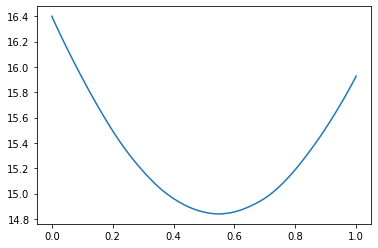

In [489]:
W_s = np.linspace(0,1,100)
scores = [ metrics.mean_absolute_error(y_true_loc,(w*y_predicted_lgb_1+(1-w)*y_predicted_lgb) ) for w in W_s]
plt.plot(W_s,scores)

In [487]:
# W_s[5]
min(scores)

14.839684007002765

Feature        object
Importance    float64
dtype: object


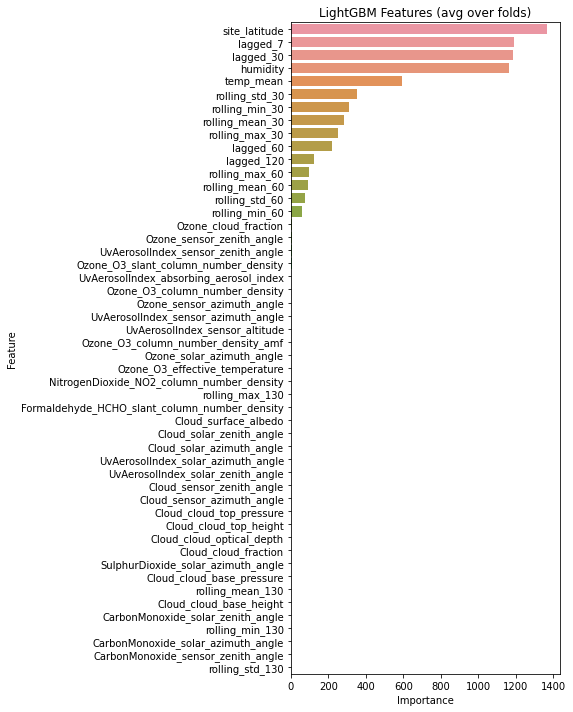

In [457]:
display_importances(features_importance_lgb_1)

In [288]:
metrics.mean_absolute_error(y_true_loc,y_predicted_lgb_)

15.002106279506789

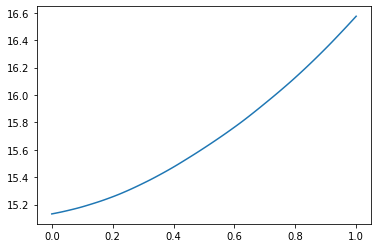

In [31]:
# cust_score(y_oof_lgb,train2)['err'].max()
# train1.groupby('site_code')['date_id'].min().max()
# train1.loc[train1.date_id==406].date
# (test_ori_loc.ID == test1.ID).all()

True

In [32]:
# y_predicted_lgb

In [232]:
# y_predicted_lgb
test1['pm2_5'] = y_predicted_lgb
test1.index = test1.ID
test1 = test1.loc[test_ori.ID]
test1 = test1.reset_index(drop = True)
test1[['ID','pm2_5']].to_csv('lgb_overfit_GTS_2.csv',index = False)

# Optuna

In [ ]:
USED_PURGED = None
K_FOLDS = 5
# kf = KFold(n_splits=N_split)
SEED = 43
import optuna
# import optuna

def objective(trial):
   
    params = { 'objective': 'reg:squarederror',
              'eval_metric': 'mae',
#             'tree_method': 'hist',
            'grow_policy' : trial.suggest_categorical ('grow_policy', ['lossguide','depthwise']),
            'learning_rate':trial.suggest_loguniform('learning_rate', 0.01, 0.2),
            'max_depth': trial.suggest_int('max_depth', 3, 31),# a virer avec'depthwise'
#             'reg_alpha': trial.suggest_loguniform('reg_alpha', 1, 10),
#             'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-15, 10.0),
            'max_delta_step':trial.suggest_int('max_delta_step', 1, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
            'colsample_bytree':trial.suggest_loguniform('colsample_bytree', 0.4, 1.0),
            'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
            'seed':1
                }
    if params['grow_policy'] == 'lossguide':
        params['max_leaves'] = trial.suggest_int('max_leaves', 1, 100)   
        
#     kf = KFold(n_splits = K_FOLDS, shuffle=True,random_state = SEED)
    
    y_predicted_xgb,models_xgb,y_oof_xgb,oof_score_xgb=train_xgb(train,features,target,test,split_typ = 'kf',tar_y = 'site_code',
                                                             params = params,split_by = 'date_id',num_iter=10000,es = 30,ve = 500)

    _,score = filter_bad(train,test,models_xgb,features,
               target,metrics.mean_absolute_error,typ = 'xgb',weigthed = True,th = 18)
    return score
    
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
# {'grow_policy': 'lossguide', 'learning_rate': 0.05079099171954073,
#  'max_depth': 18, 'max_delta_step': 5, 'min_child_weight': 3, 'colsample_bytree': 0.42373575130463065,
#  'subsample': 0.40794480292466423, 'max_leaves': 4}. Best is trial 0 with value: 10.33810914874337.

False

34

In [27]:
split_types

['gkf', 'logo', 'skf', 'sgkf', 'kf', 'purged', 'gts']

In [34]:
# test.groupby(['site_code','date']).size().idxmax()
SEED = 43
USED_PURGED = 2
shuffle = True
K_FOLDS = 5
drop_cols_0 = lagged_features + date_features + loc_features + id_features
drop_cols_1 = lagged_features + date_features[:4] + loc_features + id_features
drop_cols_2 = lagged_features[:4]+date_features + loc_features + id_features
drop_cols_3 =  date_features[:6] + loc_features + id_features

features_0  = [d for d in test1.columns if d  not in drop_cols_0]
features_1  = [d for d in test1.columns if d  not in drop_cols_1]
features_2  = [d for d in test1.columns if d  not in drop_cols_2]
features_3  = [d for d in test1.columns if d  not in drop_cols_3]
target = 'pm2_5'
# K_FOLDS = 4
# xgb_params = {'objective': 'reg:squarederror',
#               'eval_metric': 'mae','seed' : 1,'grow_policy': 'lossguide', 'learning_rate': 0.010705860757444547,'max_depth': 7, 'max_delta_step': 1, 'min_child_weight': 131, 'colsample_bytree': 0.42047871709383866, 'subsample': 0.6055990359518293, 'max_leaves': 11} #
# y_predicted_xgb,models_xgb,y_oof_xgb,oof_score_xgb=train_xgb(train,features,target,test,split_typ = 'sgkf',tar_y = 'date_id',
#                                                              params = xgb_params,split_by = 'site_code',num_iter=10000,es = 30,ve = 500) ## best with shuffle  = True, and seed= 43
# xgb_params1 = {"objective":"reg:squarederror",'learning_rate': 0.01,
#            'max_depth': 3,'eval_metric': 'mae','seed' : 1}
# xgb_params = {'objective': 'reg:squarederror',
#               'eval_metric': 'mae','seed' : 1,'grow_policy': 'depthwise', 'learning_rate': 0.011709663313511825, 'max_depth': 15, 'max_delta_step': 9, 'min_child_weight': 11, 'colsample_bytree': 0.5412984112765199, 'subsample': 0.693344385753574}

# y_predicted_xgb_0,models_xgb_0,y_oof_xgb_0,oof_score_xgb_0=train_xgb(train1,features_0,target,test1,split_typ = 'kf',tar_y = 'site_code',
#                                                              params = xgb_params1,split_by = 'date_id',num_iter=10000,es = 1,ve = 1000)
# y_predicted_xgb_1,models_xgb_1,y_oof_xgb_1,oof_score_xgb_1=train_xgb(train3,features_1,target,test3,split_typ = 'kf',tar_y = 'site_code',
#                                                              params = xgb_params,split_by = 'date_id',num_iter=10000,es = 1,ve = 1000)
# y_predicted_xgb_2,models_xgb_2,y_oof_xgb_2,oof_score_xgb_2=train_xgb(train2,features_2,target,test2,split_typ = 'gts',tar_y = 'site_code',
#                                                              params = xgb_params,split_by = 'date_id',num_iter=10000,es = 30,ve = 1000)
# y_predicted_xgb_3,models_xgb_3,y_oof_xgb_3,oof_score_xgb_3=train_xgb(train2,features_3,target,test2,split_typ = 'gts',tar_y = 'site_code',
#                                                              params = xgb_params,split_by = 'date_id',num_iter=10000,es = 30,ve = 1000)

# # preds_filtered,score = filter_bad(train,test,models_xgb,features,
# #                target,metrics.mean_absolute_error,typ = 'xgb',weigthed = True,th = 15)

In [60]:
# features[1]
preds_filtered_0,filtred_train_0,score_0 = filter_bad(train1,test1,models_xgb_0,features_0,
               target,metrics.mean_absolute_error,typ = 'xgb',weigthed = True,th = 17)
preds_filtered_1,filtred_train_1,score_1 = filter_bad(train3,test3,models_xgb_1,features_1,
               target,metrics.mean_absolute_error,typ = 'xgb',weigthed = True,th = 17)
preds_filtered_2,filtred_train_2,score_2 = filter_bad(train2,test2,models_xgb_2,features_2,
               target,metrics.mean_absolute_error,typ = 'xgb',weigthed = True,th = 17)
preds_filtered_3,filtred_train_3,score_3 = filter_bad(train2,test2,models_xgb_3,features_3,
               target,metrics.mean_absolute_error,typ = 'xgb',weigthed = True,th = 17)


weighted average  score is 13.661017409455855
weighted average  score is 5.4569587553964904
weighted average  score is 8.97291284911053
weighted average  score is 8.35715233675049


In [83]:
metrics.mean_absolute_error(train[target].values,(filtred_train_0+filtred_train_1 + filtred_train_2+filtred_train_3)/4)
# metrics.mean_absolute_error(train[target].values,filtred_train_0)
# metrics.mean_absolute_error(train[target].values,filtred_train_0)
# metrics.mean_absolute_error(train[target].values,filtred_train_0)

8.344806488696117

In [95]:
y = train[target].values
# X = 
X = np.vstack([filtred_train_0,filtred_train_1 , filtred_train_2,filtred_train_3]).transpose()
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.8893987641948224

In [98]:
X_test = np.vstack([preds_filtered_0,preds_filtered_1 , preds_filtered_2,preds_filtered_3]).transpose()

In [99]:
preds = reg.predict(X_test)

In [114]:
# metrics.mean_absolute_error(train1[target],y_oof_xgb_0)
train1['errors0'] = train1[target]-y_oof_xgb_0

In [132]:
# sns.distplot(train1[target]-y_oof_xgb_0)
# sns.distplot(train1[target]-y_oof_xgb_1)
# sns.distplot(train1[target]-y_oof_xgb_2)
# sns.distplot(train1[target]-y_oof_xgb_3)
train1.groupby('site_code').apply(lambda x : metrics.mean_absolute_error(x['pm2_5'],filtred_train_0[x.index])).sort_values() 

site_code
1     10.164466
3     10.596977
15    10.612181
16    10.997966
13    11.177375
6     11.182819
9     11.214044
28    11.496914
31    11.562983
11    11.672801
29    12.427517
10    12.427644
4     12.435509
25    12.622522
32    12.632241
12    12.723852
19    12.845805
33    12.896710
8     12.900823
18    12.964837
5     13.169624
24    13.310272
22    13.506529
7     13.910721
0     14.288905
34    14.333969
27    14.841745
2     15.625864
20    16.339524
30    16.361087
23    17.041734
26    19.910918
14    23.810468
21    26.769989
dtype: float64

In [135]:
test1[target] 
# == test1.sort_values('date')[target]

ValueError: Can only compare identically-labeled Series objects

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

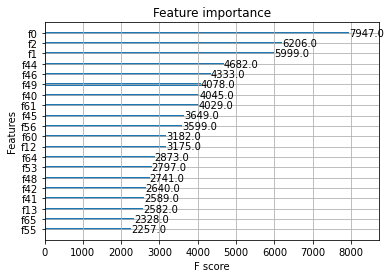

In [132]:
xgb.plot_importance(models_xgb[3],max_num_features = 20)
# models_xgb[0].feature_importances_

In [64]:
# preds_filtered,score = filter_bad(train,test,models_xgb,features,
#                target,metrics.mean_absolute_error,typ = 'xgb',weigthed = True,th = 18)

weighted average  score is 17.3437711241796


In [71]:
test2.ID == test3.ID

0       True
1       True
2       True
3       True
4       True
        ... 
4249    True
4250    True
4251    True
4252    True
4253    True
Name: ID, Length: 4254, dtype: bool

In [104]:
test1['pm2_5'] = preds
test1.index = test1.ID
test1 = test1.loc[test_ori.ID]
test1 = test1.reset_index(drop = True)
test1[['ID','pm2_5']].to_csv('average_xgb2_overfit.csv',index = False)
# .to_csv('xgb_single_kf_lagless_timeless1000.csv',index = False)

In [77]:
# preds_filtered
train1['errors']= 

array([44.52419137, 45.41014219, 47.90811091, ..., 48.77374101,
       42.18440515, 49.73935288])

In [110]:

# models_xgb
# sns.distplot(y_predicted_xgb)
# sns.distplot(y_oof_xgb)
# X_valid), 
# i = 3                     
# models_xgb[3].predict(xgb.DMatrix(train.sort_values('date').iloc[y_oof_xgb == 0][features].values),ntree_limit=models_xgb[3].best_ntree_limit)

array([ 37.251205,  31.220568,  34.851166,  40.75754 ,  32.24387 ,
        48.726456,  34.30016 ,  33.4775  ,  33.88065 ,  33.99774 ,
        38.502842,  38.569065,  36.013935,  36.526913,  35.509075,
        29.100533,  27.249197,  28.574884,  29.021954,  30.368233,
        29.264307,  26.748615,  27.150013,  28.82015 ,  27.318888,
        26.655602,  28.971195,  57.41763 ,  28.797745,  27.283482,
        79.759926,  26.148561,  55.823513,  28.814531,  48.551426,
        27.245731,  26.88734 ,  57.25544 ,  27.062008,  52.93796 ,
        66.93032 ,  29.325117,  28.16157 ,  60.346443,  26.422762,
        48.18878 ,  27.536343,  55.42668 ,  25.19204 ,  52.887035,
        23.9501  ,  54.802723,  39.599678,  29.720829,  26.82388 ,
        80.081795,  77.47978 ,  27.214575,  61.90465 ,  27.347548,
        60.240944,  27.974277,  57.92993 ,  29.816607,  25.293678,
        57.78797 ,  26.076574,  56.7068  ,  25.032053,  59.71283 ,
        58.954647,  58.93389 ,  55.040455,  26.337484,  53.890

In [32]:
# test[test_ori.ID.isin(test.ID)]
# test_ori.sort_values('date')
# test.sort_values('date')
test['pm2_5'] = y_predicted_xgb
test.index = test.ID
test = test.loc[test_ori.ID]
test = test.reset_index(drop = True)
test[['ID','pm2_5']].to_csv('xgb_single_gkf.csv',index = False)

In [51]:
X = train[features]
groups = train['date_id']
s_codes = train['site_code']
n_splits = 5 ### for self 
y = None
max_train_size = None ##

In [52]:
X, y, groups = indexable(X, y, groups)
n_samples = _num_samples(X)
n_splits = n_splits
n_folds = n_splits + 1
group_dict = {}
u, ind = np.unique(groups, return_index=True)
unique_groups = u[np.argsort(ind)]
n_samples = _num_samples(X)
n_groups = _num_samples(unique_groups)
for idx in np.arange(n_samples):
    if (groups[idx] in group_dict):
        group_dict[groups[idx]].append(idx)
    else:
        group_dict[groups[idx]] = [idx]
if n_folds > n_groups:
    raise ValueError(
        ("Cannot have number of folds={0} greater than"
         " the number of groups={1}").format(n_folds,
                                             n_groups))
    

In [53]:
np.arange(n_samples)

array([   0,    1,    2, ..., 9920, 9921, 9922])

In [54]:
group_test_size = n_groups // n_folds
group_test_starts = range(n_groups - n_splits * group_test_size,
                          n_groups, group_test_size)
for group_test_start in group_test_starts:
    train_array = []
    test_array = []
    for train_group_idx in unique_groups[:group_test_start]:
        train_array_tmp = group_dict[train_group_idx]
        train_array = np.sort(np.unique(
                              np.concatenate((train_array,
                                              train_array_tmp)),
                              axis=None), axis=None)
    train_end = train_array.size
    if max_train_size and max_train_size < train_end:
        train_array = train_array[train_end -
                                  max_train_size:train_end]
    for test_group_idx in unique_groups[group_test_start:
                                        group_test_start +
                                        group_test_size]:
        test_array_tmp = group_dict[test_group_idx]
        test_array = np.sort(np.unique(
                                      np.concatenate((test_array,
                                                      test_array_tmp)),
                             axis=None), axis=None)

In [73]:
# test_bes
# tr,val = [int(i) for i in train_array], [int(i) for i in test_array]
# si = train.groupby('site_code')['date_id'].max().min() - train.groupby('site_code')['date_id'].min().max()
# mi = train.groupby('site_code')['date_id'].min().max()

In [74]:
# train[train.date_id<mi ].shape

In [64]:
len(val)

181

In [ ]:
# y_oof_lgb.max()
preds_to_sub(test,test_best_only,'MAE_lagged_best')
# train['errors'] = train['pm2_5'] - y_oof_lgb
# test.sort_values('date').index

In [ ]:
# test['pm2_5']
train.corr()['errors'].sort_values(ascending = False, key = abs)

In [ ]:
train['errors'] = train['pm2_5'] - y_oof_lgb
a = train.site_latitude.unique()
i = 3
time_ser = fancy_interpol(train,i,th=0.8,col_pred = 'pm2_5',col_tar = 'pm2_5')
time_ser = time_ser.resample('D').mean().interpolate()

time_ser_test = test.loc[test.site_latitude == a[i]].sort_values(by = 'date').copy()
time_ser_test.index = time_ser_test.date 
time_ser_test = (time_ser_test['pm2_5'])
time_ser_test = time_ser_test.resample('D').mean().interpolate()

train_sample = time_ser.values
p_val = 0.05
try:
    seas  = 1
    model = sm.tsa.SARIMAX(train_sample,order=(2,1,0),enforce_stationarity=True,
                   seasonal_order=(0,0,1,7),trend= None)
    result = model.fit(maxiter=10000,disp=False)
    assert result.pvalues[-2]<p_val
except:
    seas = 0
    model = sm.tsa.SARIMAX(train_sample,order=(2,1,0),trend=None)
    result = model.fit(maxiter=10000,disp=False)
print(result.summary())


In [ ]:
# ((time_ser.index - time_ser.index.shift(1)).days == -1).all()

In [ ]:
# result.plot_diagnostics()
model = sm.tsa.SARIMAX(train_sample,order=(2,1,1),enforce_stationarity=True,
                   seasonal_order=(0,0,1,7),trend= None)
result = model.fit(maxiter=1000,disp=False)
print(result.summary())

In [ ]:
features_importance_lgb.sort_values('Importance',ascending = False)

In [ ]:
metrics.mean_absolute_error(train.sort_values('date')['pm2_5'],y_oof_lgb)
# pd.DataFrame({'ID' : test.ID,
#             'pm2_5':y_predicted_lgb})
# .to_csv('goupedP3_time_ser.csv',index = False)

In [ ]:
metrics.

In [ ]:
gtscv = GroupTimeSeriesSplit(n_splits=3)
train = train.sort_values('date').reset_index(drop = True)
for split_id, (train_id, val_id) in enumerate(gtscv.split(train.sort_values('date').reset_index(), groups=train["site_code"])):
    print("Split id: ", split_id, "\n") 
    print("Train id: ", train_id, "\n", "Validation id: ", val_id)
    print("Train dates: ", train.loc[train_id, "site_code"].unique(), "\n", "Validation dates: ", train.loc[val_id, "site_code"].unique(), "\n")


In [ ]:
train.loc[val_id].site_code.nunique()

In [ ]:
preds_cols = ['preds0', 'preds1', 'preds2','refined_preds0', 'refined_preds1', 'refined_preds2']

In [ ]:
for j in range(3):
    te_1['refined_preds'+str(j)] = te_1['preds'+str(j)] + te_1['correct'+str(j)]


In [ ]:
def compare(c,te,tr):
    m_train  = metrics.mean_absolute_error(tr.dropna(subset=[c])[c],
                            tr.dropna(subset=[c])['pm2_5'])
    m_test = metrics.mean_absolute_error(te.dropna(subset=[c])[c],
                            te.dropna(subset=[c])['pm2_5'])
    return m_train,m_test
l_train = []
l_test = []
for c in preds_cols:
    m_train,m_test = compare(c,te_1,tr_1)
    l_train.append(m_train)
    l_test.append(m_test)


In [ ]:
pd.DataFrame({'preds':preds_cols,
                   'score_train': l_train,
                   'score_test': l_test})

In [ ]:
train,test = preprocess(train_ori,test_ori,scale = True,target_encod = False,
              include_date = True,remove_nans = False, remove_multi = False)
features  = [d for d in test.columns if d  not in drop_cols]

tr_1,te_1 = train_aaa(train,test)
train,test = preprocess(train_ori,test_ori,scale = True,target_encod = False,
              include_date = True,remove_nans = True, remove_multi = True)
features  = [d for d in test.columns if d  not in drop_cols]

tr_2,te_2 = train_aaa(train,test)
train,test = preprocess(train_ori,test_ori,scale = True,target_encod = True,
              include_date = True,remove_nans = True, remove_multi = False)
features  = [d for d in test.columns if d  not in drop_cols]

tr_3,te_3 = train_aaa(train,test)
train,test = preprocess(train_ori,test_ori,scale = True,target_encod = True,
              include_date = True,remove_nans = True, remove_multi = True)
features  = [d for d in test.columns if d  not in drop_cols]

tr_4,te_4 = train_aaa(train,test)


In [ ]:
tr_1.to_csv('tr_1.csv',index= False)
te_1.to_csv('te_1.csv',index= False)
tr_2.to_csv('tr_2.csv',index= False)
te_2.to_csv('te_2.csv',index= False)
tr_3.to_csv('tr_3.csv',index= False)
te_3.to_csv('te_3.csv',index= False)
tr_4.to_csv('tr_4.csv',index= False)
te_4.to_csv('te_4.csv',index= False)